<a href="https://colab.research.google.com/github/cbev/sedimentGEE/blob/master/SedimentANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [81]:
import os
import tensorflow as tf
print('tf version:',tf.__version__)
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle

#### if tensorflow is not version 2.1.0, uncomment and run this code to download it to your Google Drive
# import os, sys
# from google.colab import drive
# drive.mount('/content/mnt')
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)
# !pip install --target=$nb_path  --upgrade tensorflow

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import io
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# from google.colab import files
# uploaded = files.upload()
## upload df.csv


tf version: 2.1.0


In [148]:
# Import the data and convert to values
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/files')

#df = pd.read_csv(io.BytesIO(uploaded['comp_set_2day.csv'])) 

df = pd.read_csv('comp_set_2day.csv') # assuming that saved in workspace already
df.drop(labels='Unnamed: 0',axis=1, inplace=True)
df.LID=df.LID.astype(int)

# Define which monitoring points:  Bahadurabad=1, Hardinge Bridge=2, Baruria=3, Mawa=4);
df=df[df['station'].isin([3,4])]
df=df.drop(labels=['station'],axis=1) # drop the 'station' label since want a generalized model that is not dependent on the location
#df=df.drop(labels=['station'],axis=1)

# Define which satellite(s) to get data from- uncomment option: 2=Sentinel-2; 3=MODIS; 5, 7, 8= Landsat 5, 7, 8
### Landsat 8 and Sentinel-2
#df=df[df['LID'].isin([2, 8])] 
#df=df.drop(labels=['total','month'],axis=1)
#df=df[['LID','blue','nir','red','gn','sp1','obs_mgL','month']] # testing using smaller group of variables
###df=df[['LID','rb','rn','rg','red','gn','sp1','obs_mgL','month']] # testing using smaller group of variables

### Landsat 5 and Landsat 7
df=df[df['LID'].isin([5, 7])] 
df=df.drop(labels=['LID'],axis=1)
#df=df[['LID','blue','green','nir','sp1','obs_mgL','month']] # testing using smaller group of variables

### MODIS
# df=df[df['LID'].isin([3])] 
#df=df.drop(labels=['LID','total'],axis=1)
####df=df[['blue','nir','red','obs_mgL','month']] # testing using smaller group of variables

df.reset_index(inplace=True, drop=True)
print('Variables:\n',df.head())
print(df.columns)

Variables:
      blue   green     nir    obs_mgL     red   total        rb        rg  \
0  0.0705  0.1035  0.0595  2.941176   0.0875  0.2615  1.241135  0.845411   
1  0.0610  0.0880  0.0360  1.008065   0.0690  0.2180  1.131148  0.784091   
2  0.1010  0.1430  0.1340  15.957447  0.1500  0.3940  1.485149  1.048951   
3  0.0950  0.1270  0.1190  81.379925  0.1160  0.3380  1.221053  0.913386   
4  0.0990  0.1380  0.1060  61.202991  0.1430  0.3800  1.444444  1.036232   

         rn     sp1       sp2  month  
0  1.470588  0.0955  0.904911  1      
1  1.916667  0.0785  0.820091  3      
2  1.119403  0.1465  1.182951  5      
3  0.974790  0.1215  1.032386  7      
4  1.349057  0.1405  1.142232  10     
Index(['blue', 'green', 'nir', 'obs_mgL', 'red', 'total', 'rb', 'rg', 'rn',
       'sp1', 'sp2', 'month'],
      dtype='object')


Number of input variables: 11
Number of input data: 117


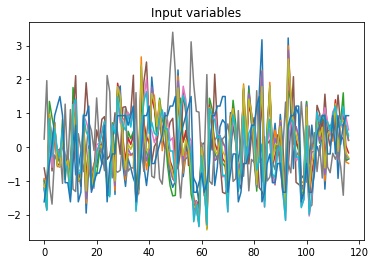

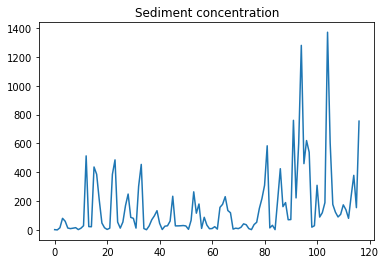

In [149]:
# Normalize the input data,
scale_inputs='yes'

if scale_inputs=='yes':
  df_prescaled = df.copy() # save a prescaled matrix
  df_scaled = df.drop(['obs_mgL'], axis=1)
  df_scaled = scale(df_scaled)
  cols = df.columns.tolist()
  cols.remove('obs_mgL')
  df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
  df_scaled = pd.concat([df_scaled, df['obs_mgL']], axis=1)
  df = df_scaled.copy()

# define input and output
X=df.drop(labels=['obs_mgL'],axis=1).values
y=df.obs_mgL.values


plt.plot(X)
plt.title('Input variables')
plt.figure()
plt.plot(y)
plt.title('Sediment concentration')
print('Number of input variables:',X.shape[1])
print('Number of input data:',X.shape[0])

36/36 [==============================] - 0s 141us/sample - loss: 99089.2891 - mse: 99089.2891
Test Error: 314.78
Test r2 -0.0686252269274863
81/81 [==============================] - 0s 72us/sample - loss: 22716.8675 - mse: 22716.8672
Train Error: 150.72
Train r2 0.36480124372479905
Total r2 0.146738279382297


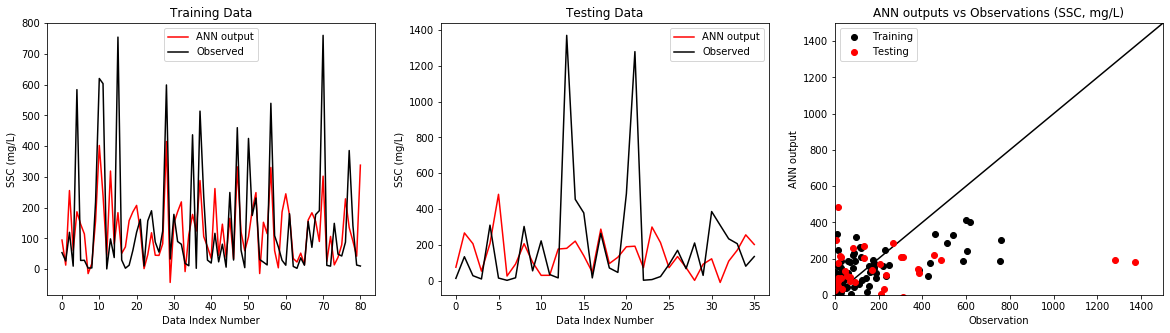

In [152]:
# Develop top ANN model
def model_base(input_dim):
  # define the keras model
  # Deep layer since a complex problem
  # add layers to the model- for each layers, define number of units and the activation function
  # use "relu' activation function to introduce non-linearity into the mode
 
  model = Sequential() # define type of model
  model.add(Dense(units=16, input_dim=input_dim, activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(16, activation= 'relu')) # hidden layer 1
  #model.add(Dense(64, activation= 'relu')) # hidden layer 2
 # model.add(Dense(32, activation= 'relu')) # hidden layer 3
  #model.add(Dense(16, activation= 'relu')) # hidden layer 4
  model.add(Dense(8, activation= 'relu')) # hidden layer 5
  #model.add(Dense(8, activation= 'relu')) # hidden layer 6
  model.add(Dense(8, activation= 'relu')) # hidden layer 8
  model.add(Dense(4, activation= 'relu')) # hidden layer 8
  model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']);

  return model

def run_ann(iterations, batch_size, epochs, test_size):
  # Split into training and testing data
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size)

  # develop the base model
  model=model_base(X_train.shape[1])

  # train and evaluate the model
  history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False); # do not include validation data
  #history=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=False); # include validation data 
  _, accuracy_top = model.evaluate(X_test, y_test) # evaluate based on the "testing" performance
  weights_top = model.get_weights()

  # Define the first parameters as the "top"
  X_train_top=X_train
  y_train_top=y_train
  X_test_top=X_test
  y_test_top=y_test
  history_top=history

  for i in range (0,iterations-1):
    print(i)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size) 
    model=model_base(X_train.shape[1])
    history_i=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False); # do not include validation data
    #history_i=model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=False); # include validation data 
    _, accuracy_i = model.evaluate(X_test, y_test); # evaluate based on the "testing" performance
    #_, accuracy_i = model.evaluate(X_train, y_train); # evaluate based on the "training" performance
    #_, accuracy_i = model.evaluate(np.concatenate([X_test, X_train]), np.concatenate([y_test, y_train])); # evaluate based on the overall performance
    weights_i = model.get_weights()

    if accuracy_i<accuracy_top:
      weights_top=weights_i;
      accuracy_top=accuracy_i;
      X_train_top=X_train
      y_train_top=y_train
      X_test_top=X_test
      y_test_top=y_test
      history_top=history_i
 
  return weights_top, accuracy_top, history_top, X_train_top, y_train_top, X_test_top, y_test_top

weights, accuracy, history, X_train, y_train, X_test, y_test= run_ann(iterations=1, batch_size=10, epochs=400, test_size=0.3)

# Set the model with the top weights
model=model_base(X_train.shape[1])
model.set_weights(weights)

fig1, (ax1, ax2, ax3) =plt.subplots(1,3,figsize=(20,5))
ax2.plot(model.predict(X_test),'r',label='ANN output')
ax2.plot(y_test,'k',label='Observed')
ax2.legend(loc='best')
ax2.set_title('Testing Data')
ax2.set_xlabel('Data Index Number')
ax2.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_test, y_test);

ax1.plot(model.predict(X_train),'r-',label='ANN output');
ax1.plot(y_train,'k-',label='Observed')
ax1.legend(loc='best')
ax1.set_title('Training Data')
ax1.set_xlabel('Data Index Number')
ax1.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_train, y_train);
xmax=1500
ymax=1500

ax3.plot([0,xmax], [0, xmax],'k-')
ax3.plot(y_train, model.predict(X_train),'ko', label='Training')
ax3.plot(y_test, model.predict(X_test), 'ro', label='Testing')
ax3.legend(loc='best')
ax3.set_title('ANN outputs vs Observations (SSC, mg/L)')
ax3.set_ylabel('ANN output')
ax3.set_xlabel('Observation')

axes = plt.gca()
axes.set_xlim([0,xmax])
axes.set_ylim([0,ymax])

r2_train = metrics.r2_score(y_train, model.predict(X_train));
r2_test = metrics.r2_score(y_test, model.predict(X_test));
r2_total = metrics.r2_score(np.concatenate([y_train, y_test]), np.concatenate([model.predict(X_train), model.predict(X_test)]));

#import matplotlib.pyplot as plt
_, accuracy = model.evaluate(X_test, y_test);
print('Test Error: %.2f' % (np.sqrt(accuracy)));
print ('Test r2', r2_test)
_, accuracy = model.evaluate(X_train, y_train);
print('Train Error: %.2f' % (np.sqrt(accuracy)))
print ('Train r2', r2_train)
print ('Total r2', r2_total)

In [0]:
# Save model
# NOTE: NEED TO CREATE A FOLDER WITH THE MODEL RUN NAME IN THE 'files' DIRECTORY
model_run='L8S2_v17' # only thing you should need to update

path='/content/drive/My Drive/Colab Notebooks/files/'+model_run+'/'
model.save(path+model_run+'.h5')
np.save(path+'X_train_'+model_run,X_train,True)
np.save(path+'y_train_'+model_run,y_train,True)
np.save(path+'X_test_'+model_run,X_test,True)
np.save(path+'y_test_'+model_run,y_test,True)


In [0]:
# Plot training & validation loss values
plt.plot(history.history['mse'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

23/23 [==============================] - 0s 76us/sample - loss: 21441.9434 - mse: 21441.9434
Test Error: 146.43
Test r2 0.6941017160761882
51/51 [==============================] - 0s 107us/sample - loss: 9918.8061 - mse: 9918.8066
Train Error: 99.59
Train r2 0.8903232975546913
Total r2 0.8395886949631353


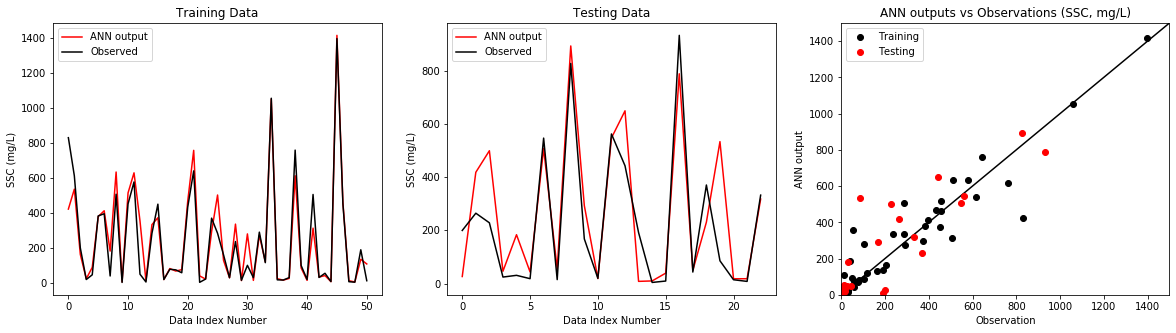

In [109]:
# Load a model, plot the results
model_run='L8S2_v17' # only thing you should need to update

path='/content/drive/My Drive/Colab Notebooks/files/'+model_run+'/'
model = tf.keras.models.load_model(path+model_run+'.h5')
X_train=np.load(path+'X_train_'+model_run+'.npy')
y_train=np.load(path+'y_train_'+model_run+'.npy')
X_test=np.load(path+'X_test_'+model_run+'.npy')
y_test=np.load(path+'y_test_'+model_run+'.npy')

fig1, (ax1, ax2, ax3) =plt.subplots(1,3,figsize=(20,5))
ax2.plot(model.predict(X_test),'r',label='ANN output')
ax2.plot(y_test,'k',label='Observed')
ax2.legend(loc='best')
ax2.set_title('Testing Data')
ax2.set_xlabel('Data Index Number')
ax2.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_test, y_test);

ax1.plot(model.predict(X_train),'r-',label='ANN output');
ax1.plot(y_train,'k-',label='Observed')
ax1.legend(loc='best')
ax1.set_title('Training Data')
ax1.set_xlabel('Data Index Number')
ax1.set_ylabel('SSC (mg/L)')
_, accuracy = model.evaluate(X_train, y_train);
xmax=1500
ymax=1500

ax3.plot([0,xmax], [0, xmax],'k-')
ax3.plot(y_train, model.predict(X_train),'ko', label='Training')
ax3.plot(y_test, model.predict(X_test), 'ro', label='Testing')
ax3.legend(loc='best')
ax3.set_title('ANN outputs vs Observations (SSC, mg/L)')
ax3.set_ylabel('ANN output')
ax3.set_xlabel('Observation')

axes = plt.gca()
axes.set_xlim([0,xmax])
axes.set_ylim([0,ymax])

r2_train = metrics.r2_score(y_train, model.predict(X_train));
r2_test = metrics.r2_score(y_test, model.predict(X_test));
r2_total = metrics.r2_score(np.concatenate([y_train, y_test]), np.concatenate([model.predict(X_train), model.predict(X_test)]));

#import matplotlib.pyplot as plt
_, accuracy = model.evaluate(X_test, y_test);
print('Test Error: %.2f' % (np.sqrt(accuracy)));
print ('Test r2', r2_test)
_, accuracy = model.evaluate(X_train, y_train);
print('Train Error: %.2f' % (np.sqrt(accuracy)))
print ('Train r2', r2_train)
print ('Total r2', r2_total)


In [0]:
# DO NOT RUN! Takeouts:

# Shallow model  
  
  #model.add(Dense(units=1, input_dim=X_train.shape[1], activation='elu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  #model.add(Dense(6, activation= 'elu')) # each successive node has hald the layers of predecessor
  #model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers


  ## Canonical Correlation Analysis 
  cca='no'
if cca=='yes':
  from sklearn.cross_decomposition import CCA
  cca = CCA(n_components=1)
  cca.fit(X, y)
  #CCA(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
  X,y = cca.transform(X, y)


# using cross validation

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def baseline_model():    
 # define the keras model
  model = Sequential() # define type of model
  # Deep layer since a complex problem
  # add layers to the model- for each layers, define number of units and the activation function
  # use "relu' activation function to introduce non-linearity into the mode; use 'elu' since will take exponential into account
  model.add(Dense(units=X_train.shape[1], input_dim=X_train.shape[1], activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(units=1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model

def large_model():    
 # define the keras model
  model = Sequential() # define type of model
  model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(64, activation= 'relu')) # each successive node has hald the layers of predecessor
  model.add(Dense(32, activation= 'relu'))
  model.add(Dense(8, activation= 'relu'))
  model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model  

# model = KerasRegressor(build_fn=baseline_model, epochs=500, verbose=0)
# # evaluate using 10-fold cross validation
# kfold = KFold(n_splits=10)
# results = cross_val_score(model, X, y, cv=kfold)
# print(results.mean())


estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=500, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))